In [1]:
from scipy import *
from scipy import ndimage, interpolate, optimize
from numpy import *
from skimage import io
from matplotlib import pyplot as plt


In [2]:
pxSize=0.1077  # um/px
dt=0.25        # sec

kT = 1.38e-23 * (273.15 + 19.3) # J

D_bead = 0.098 # um^2/s. Force-free diffusion coefficient measured on sedimenting beads (i.e. not in contact with
               # glass) with the same buffer and temperature as the bead-pulling data.
               # Calculated from `analysis_bead_diffusion/MSD_beads.ipynb`

ADUperMNP_microscope1    = 747.5   # ADU per MNP, based on single MNP imaging
fluoFactor_micr1_to_micr2= 0.312 # Measured conversion factor of GFP fluorescence between microscopes

fnForceMap='20210222_Simulated_Force_array7-ferritinH_field_z-3um_Msat-pillar-3.67e5_Msat-MNP-8.5e-20_Bext-100mT_corner-10um_angle10deg_Refine-2-2-2_rescale-px-130nm_top_Fxyz.tif'
pxSizeForceMap=0.13 # um/px

lfn=[['20211208_5um-beads-Ab-Ferritin-H_array7_2_sel_maxima_bead1.trk2',  1, 1000,  584, 0, -1, 2494447],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_4_sel_maxima_bead1.trk2',  1,  988,  840, 0, 14, 2609566],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_4_sel_maxima_bead2.trk2',  1,  988,  840, 0, -1, 1753155],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_6_sel_maxima_bead1.trk2',  0, 1060, 1272, 0, 85,  852757],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_6_sel_maxima_bead2.trk2',  0, 1060, 1272, 0, -1, 2685928],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_8_sel_maxima_bead1.trk2',  1, 1104, 1260, 0, -2, 2501088],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_10_sel_maxima_bead1.trk2', 1,  988,  908, 0,  8, 1914842],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_10_sel_maxima_bead2.trk2', 1,  988,  908, 0, -1, 2281790],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_12_sel_maxima_bead1.trk2', 1, 1270, 1496, 0, -1, 2248927],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_12_sel_maxima_bead2.trk2', 1, 1270, 1496, 0, 62, 2088832],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_15_sel_maxima_bead1.trk2', 1, 1236,  500, 0, -1, 1519059],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_17_sel_maxima_bead1.trk2', 0, 1476, 1236, 0, -1, 2029084],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_17_sel_maxima_bead2.trk2', 0, 1476, 1236, 0, 18, 2089320],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_19_sel_maxima_bead1.trk2', 0, 1048, 1248, 0, -1, 3369157],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_21_sel_maxima_bead1.trk2', 0, 1008, 1464, 0,  4, 1812859],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_21_sel_maxima_bead2.trk2', 0, 1008, 1464, 0, -1, 2483115.321],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_21_sel_maxima_bead3.trk2', 0, 1008, 1464, 0,  3, 2577129],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_23_sel_maxima_bead1.trk2', 0, 976,  1104, 0, -1, 1970627],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_25_sel_maxima_bead1.trk2', 1, 1124, 1228, 0, -1, 2116937],
     ['20211208_5um-beads-Ab-Ferritin-H_array7_27_sel_maxima_bead1.trk2', 0, 964,  1392, 0, -1, 2414700],
     #  File name,
     #  top (1) or bottom (0) corner of pillar,
     #  x and
     #  y coordinates of pillar corner,
     #  first and
     #  last frame to use (last=contact with pillar)
     #  raw intensity (ADU) of bead
     ]

     #  Estimated number of MNPs
for a in lfn: a.append(a[-1]/(ADUperMNP_microscope1*fluoFactor_micr1_to_micr2))


In [3]:
# Make list of 20 unique colors
changeLuminance=(lambda col, a: ''.join([hex(clip(int(256-(256-int(col[2*i:2*(i+1)],16))*a),0,255))[-2:].replace('x','0') for i in [0,1,2]]))
lCol=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
lCol=['#'+changeLuminance(c[1:],1.3) for c in lCol]+['#'+changeLuminance(c[1:],.7) for c in lCol]

if 0: # Display legend
    plt.figure()
    for i in range(20):
        plt.scatter(0,-i,s=20,fc='none',ec=lCol[i])
        plt.plot(r_[1,2], r_[0,0]-i,c=lCol[i])
    plt.xlim(-5,5)
    plt.savefig('fig_beads_legend.pdf')
    


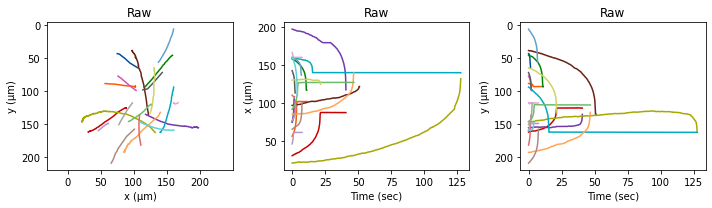

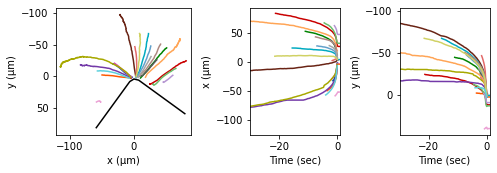

In [4]:
### Load traces -----------------###

datasets=[loadtxt(fn[0]) for fn in lfn]
# Columns: frame, x, y, nan, intensity, ...

fig,ax=plt.subplots(1,3,figsize=(10,3))
plt.sca(ax[0]); plt.gca().set_aspect('equal', 'datalim'); plt.title('Raw')
plt.xlabel("x (µm)"); plt.ylabel("y (µm)"); plt.gca().invert_yaxis()
plt.sca(ax[1]); plt.title('Raw')
plt.xlabel("Time (sec)"); plt.ylabel("x (µm)");
plt.sca(ax[2]); plt.title('Raw')
plt.xlabel("Time (sec)"); plt.ylabel("y (µm)"); plt.gca().invert_yaxis()
for i,d in enumerate(datasets):
    ax[0].plot(d[:,1]*pxSize,d[:,2]*pxSize,c=lCol[i])
    ax[1].plot(d[:,0]*dt,d[:,1]*pxSize,c=lCol[i])
    ax[2].plot(d[:,0]*dt,d[:,2]*pxSize,c=lCol[i])
plt.tight_layout()
plt.show()


### Center traces -----------------###

datasets2=[]
# Columns: frame (centered),
#          x, y (px, centered),

for i,d in enumerate(datasets):
    
    # Align traces on time of contact with pillar (optional)
    frame =d[:,0]-d[lfn[i][5],0]
    # Center coordinates on pillar corner. Rotate when pillar corner is a 'bottom' corner
    xy    =(d[:,1:3]-array(lfn[i][2:4]))*[-1,1][lfn[i][1]]
    
    datasets2.append(c_[frame, xy])

fig,ax=plt.subplots(1,3,figsize=(7,2.5),gridspec_kw={'width_ratios':[3,2,2]})
for i,d in enumerate(datasets2):
    #f0,f1=lfn[i][4],(lfn[i][5])%d.shape[0]+1
    ax[0].plot(d[:,1]*pxSize,d[:,2]*pxSize,c=lCol[i])
    ax[1].plot(d[:,0]*dt,d[:,1]*pxSize,c=lCol[i])
    ax[2].plot(d[:,0]*dt,d[:,2]*pxSize,c=lCol[i])
plt.sca(ax[0]); plt.gca().set_aspect('equal', 'datalim');
#plt.xlim(-135,100); plt.ylim(60,-100); 
plt.xlabel("x (µm)"); plt.ylabel("y (µm)"); plt.gca().invert_yaxis()
plt.sca(ax[1]); plt.xlim(-30,1); 
plt.xlabel("Time (sec)"); plt.ylabel("x (µm)");
plt.sca(ax[2]); plt.xlim(-30,1); 
plt.xlabel("Time (sec)"); plt.ylabel("y (µm)"); plt.gca().invert_yaxis()
#Draw pillar
a=9.*pi/180; r=10.
ax[0].plot(r_[-cos(pi/4+a)*100, -cos(pi/4+a)*r, -cos(pi/2+a)*r*(2**.5-1), sin(pi/4+a)*r, sin(pi/4+a)*100],
           r_[ sin(pi/4+a)*100,  sin(pi/4+a)*r,  sin(pi/2+a)*r*(2**.5-1), cos(pi/4+a)*r, cos(pi/4+a)*100], c='k')
plt.tight_layout()
plt.savefig('fig_beads_traj.pdf')


In [5]:
forceMap=io.imread(fnForceMap).swapaxes(0,1)

calcs=[] # Calculation results (each element uses frames i and i+1)
# Columns: frame,
#          x, y (um),
#          distance to end point (um),
#          vx, vy (um/s),
#          calculated Fx, Fy     (pN, total on bead),
#          expected   Fx, Fy, Fz (pN, total on bead)

### Center traces
for i,d in enumerate(datasets2):
    
    f0,f1=lfn[i][4],(lfn[i][5])%d.shape[0]+1
    frame=d[f0:f1,0]
    xy   =d[f0:f1][:,1:3]
        
    # Calculate speed (in um/s and with y-axis pointing up) and deduce force
    v      = (xy[1:]-xy[:-1])*pxSize/dt *r_[1,-1] # um/s
    F_calc = v*kT/D_bead *1e6/1e-12               # pN. Einstein fluctuation-dissipation relationship

    # Calculate expected force from force map and number of MNPs on bead
    xy_forceMapCoo = xy * pxSize/pxSizeForceMap + (array(forceMap.shape[:2])-1)/2
    F_expect       = lfn[i][7]/1e3 * \
        array([ [ ndimage.interpolation.map_coordinates(forceMap[:,:,i],
                      array([ xy_forceMapCoo[j] +(xy_forceMapCoo[j+1]-xy_forceMapCoo[j])*a for a in r_[0:1:11j]]).T,
                      order=1, mode='constant', cval=nan).mean(0)
                 for j in range(xy_forceMapCoo.shape[0]-1)]
               for i in r_[:3]]).T    
    
    frame_mid=(frame[:-1]+frame[1:])/2
    xy_mid   =(   xy[:-1]+   xy[1:])/2
    calcs.append(c_[frame_mid, xy_mid*pxSize,
                    ((xy_mid-xy[f1-1])**2).sum(1)**.5*pxSize,
                    v, F_calc, F_expect])
    
    # Remove inaccurate point due to time gap between the two movies used to record this trajectory
    if lfn[i][0]=='20211208_5um-beads-Ab-Ferritin-H_array7_12_sel_maxima_bead1.trk2':
        calcs[-1]=r_[calcs[-1][:492],calcs[-1][493:]]


20211208_5um-beads-Ab-Ferritin-H_array7_2_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_4_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_4_sel_maxima_bead2.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_6_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_6_sel_maxima_bead2.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_8_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_10_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_10_sel_maxima_bead2.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_12_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_12_sel_maxima_bead2.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_15_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_17_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_17_sel_maxima_bead2.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_19_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-H_array7_21_sel_maxima_bead1.trk2
20211208_5um-beads-Ab-Ferritin-

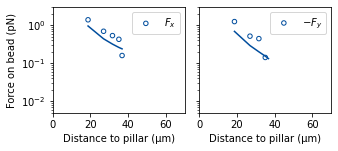

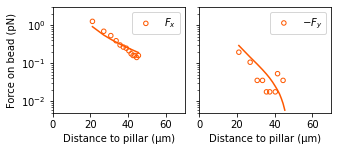

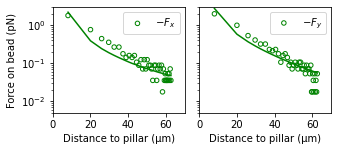

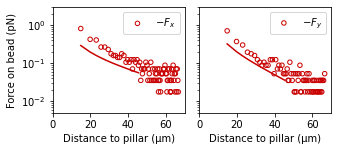

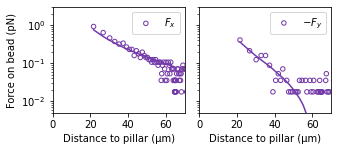

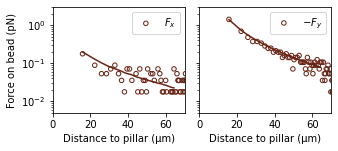

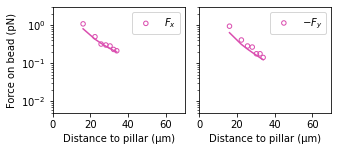

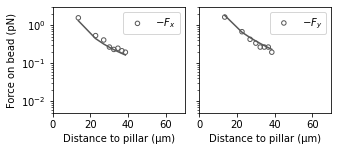

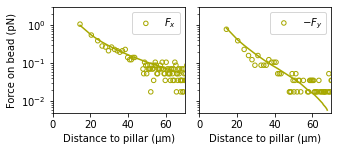

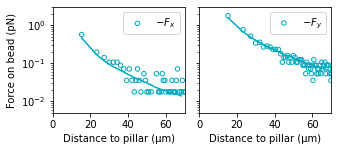

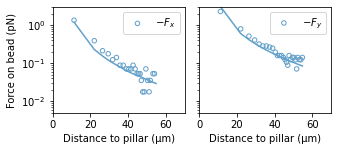

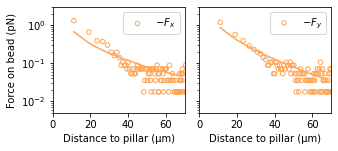

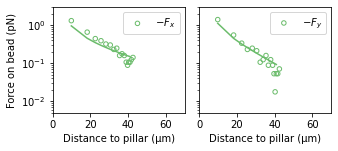

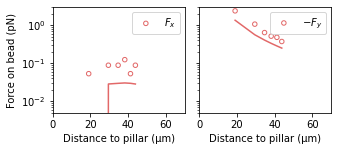

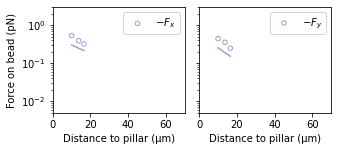

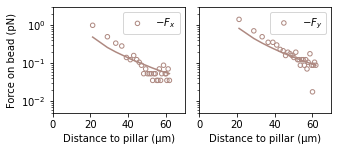

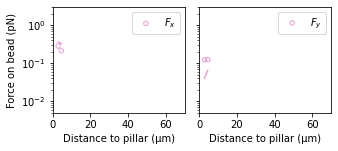

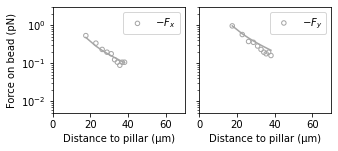

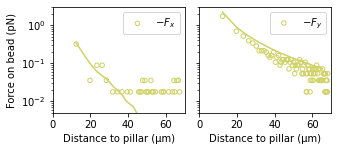

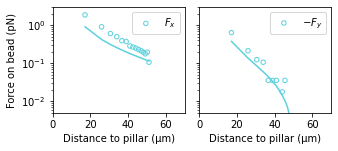

In [6]:
for i,c in enumerate(calcs[:]):
    print(lfn[i][0])
    fig,ax=plt.subplots(1,2,sharex='col',sharey=True,figsize=(4.8,2.2))

#    plt.sca(ax[0]);
#    plt.scatter(c[:-1,0],abs(c[:-1,6]),s=20,ec='C%d'%i,fc='none');
#    plt.plot(   c[:-1,0],abs(c[:-1,8]),c='C%d'%i)
#    plt.sca(ax[1]);
#    plt.scatter(c[:-1,0],-c[:-1,7],s=20,ec='C%d'%i,fc='none');
#    plt.plot(   c[:-1,0],-c[:-1,9],c='C%d'%i)
    Fx_neg=(median(c[isfinite(c[:,8]),8][:-1])<0)*1
    Fy_neg=(median(c[isfinite(c[:,9]),9][:-1])<0)*1
    plt.sca(ax[0]);
    plt.scatter(c[:-1,3],c[:-1,6]*[1,-1][Fx_neg],s=20,fc='none', label="$"+['','-'][Fx_neg]+"F_x$",ec=lCol[i])
    plt.plot(   c[:-1,3],c[:-1,8]*[1,-1][Fx_neg],c=lCol[i])
    plt.sca(ax[1]);
    plt.scatter(c[:-1,3],c[:-1,7]*[1,-1][Fy_neg],s=20,fc='none', label="$"+['','-'][Fy_neg]+"F_y$",ec=lCol[i])
    plt.plot(   c[:-1,3],c[:-1,9]*[1,-1][Fy_neg],c=lCol[i])

#    plt.sca(ax[0]);
#    plt.xlabel("Time (frame)"); plt.ylabel("$F_x$ (pN)"); plt.xlim(-50,0); plt.yscale('log'); plt.ylim(.5e-2,3); 
#    plt.sca(ax[1]);
#    plt.xlabel("Time (frame)"); plt.ylabel("$F_y$ (pN)"); plt.xlim(-50,0); plt.yscale('log'); plt.ylim(.5e-2,3); 
    plt.sca(ax[0]); plt.legend()
    plt.xlabel("Distance to pillar (µm)"); plt.ylabel("Force on bead (pN)"); plt.xlim(0, 70); plt.yscale('log'); plt.ylim(.5e-2,3); 
    plt.sca(ax[1]); plt.legend()
    plt.xlabel("Distance to pillar (µm)"); plt.xlim(0, 70); plt.yscale('log'); plt.ylim(.5e-2,3); 

    plt.tight_layout()
    plt.savefig('fig_beads_compare_%02d.pdf'%i)


<ipython-input-7-190a113a4d73>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Measured / Predicted = 1.28


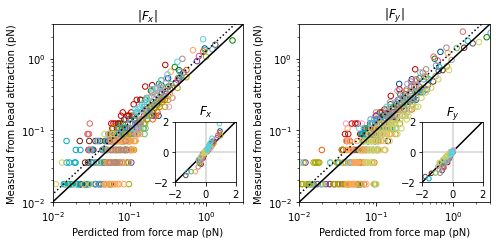

In [7]:
forceCutoffFit=0.15 # pN

fig,ax=plt.subplots(1,2,figsize=(7,3.5))
ax=r_[ax,fig.add_axes([.355,.26,.12,.24]), fig.add_axes([.845,.26,.12,.24])]

ptsForFit=[]
for i,c in enumerate(calcs[:]):
    plt.sca(ax[0]); plt.scatter(abs(c[:-1,8]),abs(c[:-1,6]),s=30,fc='none',ec=lCol[i]);
    plt.sca(ax[1]); plt.scatter(abs(c[:-1,9]),abs(c[:-1,7]),s=30,fc='none',ec=lCol[i]);
    plt.sca(ax[2]); plt.scatter(c[:-1,8],c[:-1,6],s=20,fc='none',ec=lCol[i]);
    plt.sca(ax[3]); plt.scatter(c[:-1,9],c[:-1,7],s=20,fc='none',ec=lCol[i]);
    sel=where(isfinite(c[:-1,8])*(c[:-1,8]>forceCutoffFit))[0]; ptsForFit.append(c[sel][:,[8,6]])
    sel=where(isfinite(c[:-1,9])*(c[:-1,9]>forceCutoffFit))[0]; ptsForFit.append(c[sel][:,[9,7]])

#fit=optimize.fmin(lambda p: sum((p*r_[c[:-1,8],c[:-1,9]]-r_[c[:-1,6],c[:-1,7]])**2),1.)
#fit=optimize.fmin(lambda p: sum(concatenate([(lambda a: a[where(isfinite(a))])((p*r_[c[:-1,8],c[:-1,9]]-r_[c[:-1,6],c[:-1,7]])**2) for c in calcs])),1.,disp=0)
fit=optimize.fmin(lambda p: sum(diff(concatenate(ptsForFit)*r_[p,1],axis=1)**2),1.,disp=0)

x=r_[-10,10]
plt.sca(ax[0]); plt.plot(x,x,c='k',zorder=10); plt.plot(x,x*fit,c='k',ls=':',zorder=10)
plt.xscale('log'); plt.yscale('log');
plt.xlabel("Perdicted from force map (pN)"); plt.ylabel("Measured from bead attraction (pN)"); plt.title("$|F_x|$");
plt.xlim(1.e-2,3); plt.ylim(1.e-2,3)
plt.sca(ax[1]); plt.plot(x,x,c='k',zorder=10); plt.plot(x,x*fit,c='k',ls=':',zorder=10)
plt.xscale('log'); plt.yscale('log');
plt.xlabel("Perdicted from force map (pN)"); plt.ylabel("Measured from bead attraction (pN)"); plt.title("$|F_y|$"); 
plt.xlim(1.e-2,3); plt.ylim(1.e-2,3)
plt.sca(ax[2]); plt.plot(x,x,c='k',zorder=0); plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0); 
plt.title("$F_x$"); plt.xlim(-2.,2.); plt.ylim(-2,2)
plt.sca(ax[3]); plt.plot(x,x,c='k',zorder=0); plt.axvline(0,c='lightgray',zorder=0); plt.axhline(0,c='lightgray',zorder=0); 
plt.title("$F_y$"); plt.xlim(-2,2); plt.ylim(-2,2)

plt.tight_layout()
plt.savefig('fig_beads_scatter.pdf')

print('Measured / Predicted = %.2f'%fit)


Bead 1: 1.52
Bead 2: 1.07
Bead 3: 1.12
Bead 4: 2.13
Bead 5: 1.13
Bead 6: 0.94
Bead 7: 1.23
Bead 8: 1.01
Bead 9: 0.93
Bead 10: 1.06
Bead 11: 1.02
Bead 12: 1.36
Bead 13: 1.20
Bead 14: 1.72
Bead 15: 1.67
Bead 16: 1.41
Bead 17: 0.80
Bead 18: 0.91
Bead 19: 0.75
Bead 20: 1.90


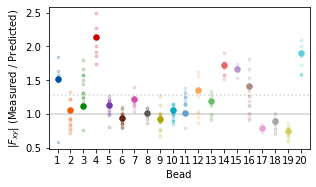

In [8]:
forceCutoff=0.15 # pN

plt.figure(figsize=(4.5,2.7))

lMeans=[]
for i,c in enumerate(calcs[:]):
    Fxy_meas=sum(c[:-1,[6,7]]**2,1)**.5
    Fxy_pred=sum(c[:-1,[8,9]]**2,1)**.5
    sel=where(isfinite(Fxy_meas)*(Fxy_meas>forceCutoff)*isfinite(Fxy_pred)*(Fxy_pred>forceCutoff))[0];
    plt.scatter(i+1+0*Fxy_meas[sel],Fxy_meas[sel]/Fxy_pred[sel],s=8,c=lCol[i],alpha=.2);
    lMeans.append(mean(Fxy_meas[sel])/mean(Fxy_pred[sel]))
    plt.scatter(i+1,lMeans[-1],s=30,c=lCol[i]);
    print("Bead %d: %.2f"%(i+1,mean(Fxy_meas[sel])/mean(Fxy_pred[sel])))

plt.axhline(1,c='lightgray',zorder=0)
plt.axhline(fit,c='lightgray',zorder=0,ls=':')
plt.xlabel("Bead"); plt.ylabel("$|F_{xy}|$ (Measured / Predicted)");
plt.xlim(.3,20.7); plt.xticks(range(1,21))

plt.tight_layout()
plt.savefig('fig_beads_individual_beads.pdf')


In [9]:
sort(lMeans), median(lMeans)

(array([0.75181834, 0.79771823, 0.90664018, 0.93432323, 0.94282633,
        1.01126214, 1.0226891 , 1.05801286, 1.06604067, 1.11963002,
        1.13350258, 1.19870172, 1.22822181, 1.3580751 , 1.40922762,
        1.51735376, 1.67227578, 1.72159114, 1.89645435, 2.13375646]),
 1.1265663029157216)

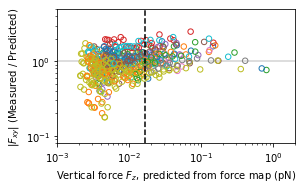

In [10]:
v_sedimentation= 0.4 # um/s
#------------

Fz_toLiftBead=v_sedimentation*kT/D_bead *1e6/1e-12 # pN

fig=plt.figure(figsize=(4.3,2.7))

for i,c in enumerate(calcs[:]):
    plt.scatter(c[:-1,10],sum(c[:-1,[6,7]]**2,1)**.5/sum(c[:-1,[8,9]]**2,1)**.5,s=30,ec='C%d'%i,fc='none');

plt.axhline(1,c='lightgray',zorder=0); plt.axvline(Fz_toLiftBead,c='k',ls='--',zorder=10)
plt.xscale('log'); plt.yscale('log');
plt.xlabel("Vertical force $F_z$, predicted from force map (pN)"); plt.ylabel("$|F_{xy}|$ (Measured / Predicted)");
plt.xlim(1e-3,2); plt.ylim(.8e-1,5)

plt.tight_layout()
plt.show()

